# Smooth the Data and Compute Derivatives
The data has a lot of noise in it, which is going to make derivatives particularly problematic

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pandas as pd
import numpy as np

## Load in the Data
We'll use the pickle file saved earlier

In [2]:
raw_data = pd.read_pickle('datasets/initial_data.pkl')
raw_data.head(3)

,frame_id,void_radii,void_count,radius_total,radius_mean,radius_stddev,surfarea_total,surfarea_mean,surfarea_stddev,volume_total,volume_mean,volume_stddev
0,1,"[20.115949960445413, 14.948362455500638, 25.86...",51,1159.630190,22.737847,3.434627,338904.0,6645.176471,1904.134395,2.679521e+06,52539.617723,21444.502043
1,2,"[25.30376130259481, 16.840846433292995, 25.974...",52,1175.418020,22.604193,3.563824,342180.0,6580.384615,1923.493918,2.696669e+06,51859.015468,21163.135165
2,3,"[20.416336496974036, 19.242504387508777, 26.16...",52,1161.311616,22.332916,3.876824,335736.0,6456.461538,2040.417580,2.635457e+06,50681.869873,22248.809614


## Initial Smoothing
Our data has a lot of large jumps, so we'll smooth it out with a median filter first

In [3]:
data = raw_data.rolling(65, center=True).median()

In [4]:
# Remove points that are too close to the edges
data = data[~data.isnull().any(axis=1)]

Text(0, 0.5, 'Radius (nm)')

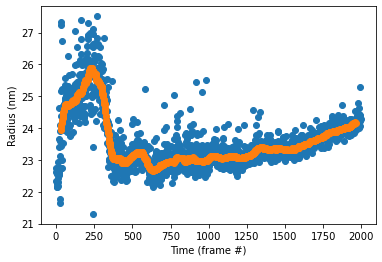

In [5]:
fig, ax = plt.subplots()

x = np.arange(len(data))
ax.scatter(raw_data['frame_id'], raw_data['radius_mean'])
ax.scatter(data['frame_id'], data['radius_mean'])

ax.set_xlabel('Time (frame #)')
ax.set_ylabel('Radius (nm)')

## Try out smoothing splines
The key way to adjust a spline in scipy's [`UnivariateSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) is the "smoothing factor," which controls the number of knots on the spline by asserting the error between the spline and the original data stays below a threshold.

We are going to make that threshold equal to 10% of the value fo the data points.

In [6]:
spline = UnivariateSpline(data['frame_id'], data['radius_mean'], k=5, s=(data['radius_mean'].median() * 0.01) ** 2 * len(data))

Text(0, 0.5, 'Radius (nm)')

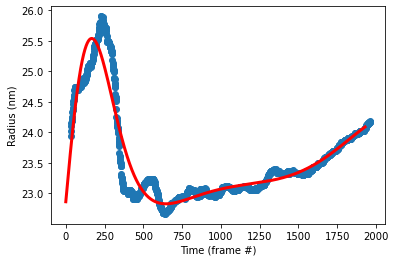

In [7]:
fig, ax = plt.subplots()

x = np.arange(len(data))
ax.scatter(data['frame_id'], data['radius_mean'])

ax.plot(x, spline(x), 'r', lw=3)

ax.set_xlabel('Time (frame #)')
ax.set_ylabel('Radius (nm)')

**TODO**: Probably good enough for the time being, though it seems too smooth. Eventually impose a rule like "select the maximum `s` such that derivatives that there are no outliers above 4 * IQR"

Text(0, 0.5, '$d$Radius/$dt$ (nm/s)')

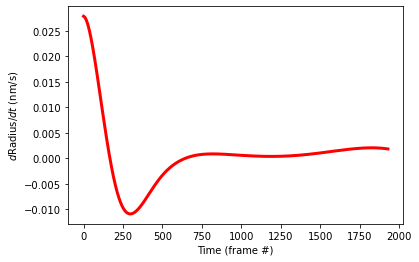

In [8]:
fig, ax = plt.subplots()

ax.plot(x, spline.derivative(1)(x), 'r', lw=3)

ax.set_xlabel('Time (frame #)')
ax.set_ylabel('$d$Radius/$dt$ (nm/s)')

## Run them on all columns
So that we get smooth derivatives for everything

In [9]:
data_cols = data.columns[1:] # Skip frame_id, void_radii

In [10]:
smooth_data = data.copy()
for c in tqdm(data_cols):
    # Fit a smoothing spline
    spline = UnivariateSpline(data['frame_id'], data[c], k=5, s=(data[c].median() * 0.01) ** 2 * len(data))
    
    # Smooth the data
    smooth_data[c] = spline(data['frame_id'])
    
    # Compute derivatives of the smoothed data
    smooth_data[f'{c}_dt'] = spline.derivative(1)(data['frame_id'])

100%|██████████| 10/10 [00:00<00:00, 426.42it/s]


In [11]:
data

,frame_id,void_count,radius_total,radius_mean,radius_stddev,surfarea_total,surfarea_mean,surfarea_stddev,volume_total,volume_mean,volume_stddev
32,33.0,55.0,1223.710309,23.945742,4.171713,393084.0,7503.639344,2273.147812,3.624017e+06,64627.902598,25592.679213
33,34.0,58.0,1424.849871,24.025747,4.171713,446958.0,7531.403226,2273.147812,3.773123e+06,64666.925170,26042.573474
34,35.0,58.0,1432.019484,24.102505,4.171713,453024.0,7548.000000,2273.147812,3.834438e+06,64844.603913,26042.573474
35,36.0,58.0,1446.769030,24.153357,4.171713,456633.0,7560.580645,2273.147812,3.864942e+06,64938.141394,26103.481797
36,37.0,59.0,1452.440130,24.181701,4.084902,457227.0,7560.692308,2273.147812,3.890676e+06,64951.250287,26316.646274
...,...,...,...,...,...,...,...,...,...,...,...
1957,1958.0,299.0,7237.819780,24.191535,6.976470,2380644.0,7953.780405,4416.340754,2.221866e+07,74261.887202,60818.782662
1958,1959.0,300.0,7238.814670,24.172318,6.976470,2381013.0,7953.351171,4416.340754,2.222834e+07,74205.160839,60818.782662
1959,1960.0,300.0,7238.814670,24.172318,6.976470,2381013.0,7953.351171,4418.233452,2.223382e+07,74205.160839,60870.953904
1960,1961.0,300.0,7239.154863,24.172318,6.976470,2381877.0,7953.351171,4418.233452,2.224490e+07,74205.160839,60870.953904


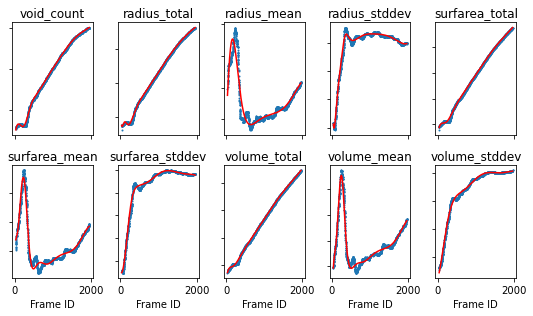

In [12]:
fig, axs = plt.subplots(2, 5, sharex=True, figsize=(7.5, 4.5))


for c, ax in zip(data_cols, axs.flatten()):
    ax.scatter(data['frame_id'], data[c], s=1)
    ax.plot(smooth_data['frame_id'], smooth_data[c], 'r')
    
    ax.set_yticklabels([])
    ax.set_title(c)
    
for ax in axs[-1, :]:
    ax.set_xlabel('Frame ID')
    
fig.tight_layout()

## Save Data
In both CSV and pickle formats

In [13]:
smooth_data.to_csv('datasets/smooth_data.csv', index=False)

In [14]:
smooth_data.to_pickle('datasets/smooth_data.pkl')